In [23]:

import collections
import math
import time
import matplotlib.pyplot as plt
import sys

import cv2
import numpy
import tensorflow as tf

import common
import model


def make_scaled_ims(im, min_shape):
    ratio = 1. / 2 ** 0.5
    shape = (im.shape[0] / ratio, im.shape[1] / ratio)

    while True:
        shape = (int(shape[0] * ratio), int(shape[1] * ratio))
        if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
            break
        yield cv2.resize(im, (shape[1], shape[0]))

In [24]:
def detect(im, param_vals):
    """
    Detect all bounding boxes of number plates in an image.
    :param im:
        Image to detect number plates in.
    :param param_vals:
        Model parameters to use. These are the parameters output by the `train`
        module.
    :returns:
        Iterable of `bbox_tl, bbox_br, letter_probs`, defining the bounding box
        top-left and bottom-right corners respectively, and a 7,36 matrix
        giving the probability distributions of each letter.
    """

    # Convert the image to various scales.
    scaled_ims = list(make_scaled_ims(im, model.WINDOW_SHAPE))

    # Load the model which detects number plates over a sliding window.
    x, y, params = model.get_detect_model()

    # Execute the model at each scale.
    with tf.Session(config=tf.ConfigProto()) as sess:
        y_vals = []
        
        for scaled_im in scaled_ims:
            feed_dict = {x: numpy.stack([scaled_im])}
            feed_dict.update(dict(zip(params, param_vals)))
            y_vals.append(sess.run(y, feed_dict=feed_dict))
            plt.imshow(scaled_im)
            plt.show()
    writer = tf.summary.FileWriter("logs/", sess.graph)

    # Interpret the results in terms of bounding boxes in the input image.
    # Do this by identifying windows (at all scales) where the model predicts a
    # number plate has a greater than 50% probability of appearing.
    #
    # To obtain pixel coordinates, the window coordinates are scaled according
    # to the stride size, and pixel coordinates.
    count_detect = 0
    for i, (scaled_im, y_val) in enumerate(zip(scaled_ims, y_vals)):
        for window_coords in numpy.argwhere(y_val[0, :, :, 0] >
                                            -math.log(1. / 0.99 - 1)):
            letter_probs = (y_val[0,
                            window_coords[0],
                            window_coords[1], 1:].reshape(
                7, len(common.CHARS)))
            letter_probs = common.softmax(letter_probs)

            img_scale = float(im.shape[0]) / scaled_im.shape[0]

            bbox_tl = window_coords * (8, 4) * img_scale
            bbox_size = numpy.array(model.WINDOW_SHAPE) * img_scale

            present_prob = common.sigmoid(
                y_val[0, window_coords[0], window_coords[1], 0])
            count_detect += 1
            yield bbox_tl, bbox_tl + bbox_size, present_prob, letter_probs
            print("count detect:", count_detect)
            print("show return window: ", bbox_tl, "return windows box: ", bbox_tl + bbox_size)
            print("present: ", present_prob)
            print("letter: ", letter_probs_to_code(letter_probs))

In [25]:

def _overlaps(match1, match2):
    bbox_tl1, bbox_br1, _, _ = match1
    bbox_tl2, bbox_br2, _, _ = match2
    return (bbox_br1[0] > bbox_tl2[0] and
            bbox_br2[0] > bbox_tl1[0] and
            bbox_br1[1] > bbox_tl2[1] and
            bbox_br2[1] > bbox_tl1[1])

In [26]:

def _group_overlapping_rectangles(matches):
    matches = list(matches)
    num_groups = 0
    match_to_group = {}
    for idx1 in range(len(matches)):
        for idx2 in range(idx1):
            if _overlaps(matches[idx1], matches[idx2]):
                match_to_group[idx1] = match_to_group[idx2]
                break
        else:
            match_to_group[idx1] = num_groups
            num_groups += 1

    groups = collections.defaultdict(list)
    for idx, group in match_to_group.items():
        groups[group].append(matches[idx])

    return groups

In [27]:

def post_process(matches):
    """
    Use non-maximum suppression on the output of `detect` to filter.
    Take an iterable of matches as returned by `detect` and merge duplicates.
    Merging consists of two steps:
      - Finding sets of overlapping rectangles.
      - Finding the intersection of those sets, along with the code
        corresponding with the rectangle with the highest presence parameter.
    """
    groups = _group_overlapping_rectangles(matches)

    for group_matches in groups.values():
        mins = numpy.stack(numpy.array(m[0]) for m in group_matches)
        maxs = numpy.stack(numpy.array(m[1]) for m in group_matches)
        present_probs = numpy.array([m[2] for m in group_matches])
        letter_probs = numpy.stack(m[3] for m in group_matches)

        yield (numpy.max(mins, axis=0).flatten(),
               numpy.min(maxs, axis=0).flatten(),
               numpy.max(present_probs),
               letter_probs[numpy.argmax(present_probs)])

In [28]:
def letter_probs_to_code(letter_probs):
    return "".join(common.CHARS[i] for i in numpy.argmax(letter_probs, axis=1))

In [29]:
def detect_plate(file_in, weight, file_out):
    print("detect start! ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    im = cv2.imread(file_in)

    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) / 255.

    plt.imshow(im_gray)
    plt.show()

    f = numpy.load(weight)

    for ii in numpy.load(weight):
        if type(f[ii]) != numpy.ndarray:
            f.files.pop(f.files.index(ii))

    param_vals = [f[n] for n in sorted(f.files, key=lambda s: int(s[-1]))]

    for pt1, pt2, present_prob, letter_probs in post_process(
            detect(im_gray, param_vals)):
        pt1 = tuple(reversed(list(map(int, pt1))))
        pt2 = tuple(reversed(list(map(int, pt2))))

        code = letter_probs_to_code(letter_probs)

        color = (0.0, 255.0, 0.0)
        cv2.rectangle(im, pt1, pt2, color)

        cv2.putText(im,
                    code,
                    pt1,
                    cv2.FONT_HERSHEY_PLAIN,
                    1.5,
                    (0, 0, 0),
                    thickness=5)

        cv2.putText(im,
                    code,
                    pt1,
                    cv2.FONT_HERSHEY_PLAIN,
                    1.5,
                    (255, 255, 255),
                    thickness=2)

    cv2.imwrite(file_out, im)
    print("show result:")
    plt.imshow(im)
    plt.show()
    print("detect end", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))


detect start!  2018-10-01 09:21:23


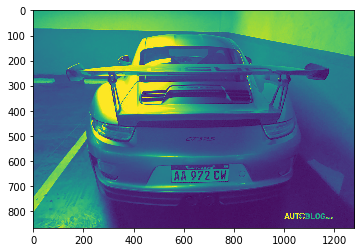

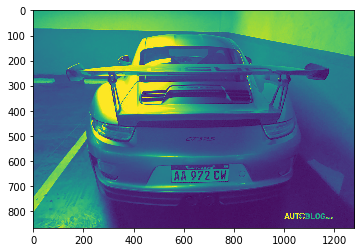

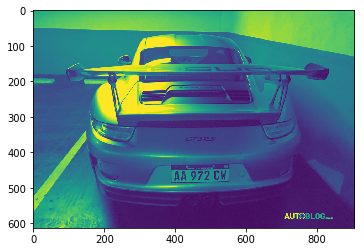

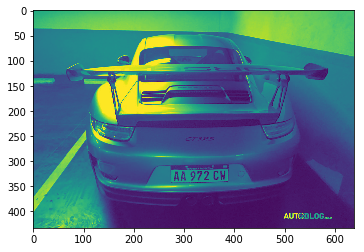

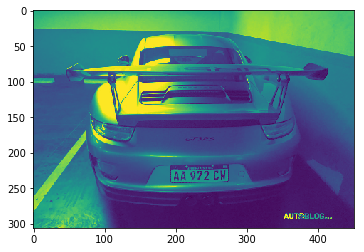

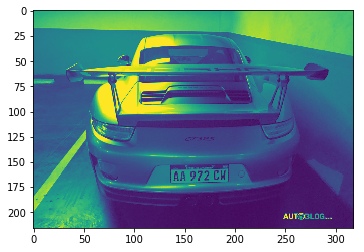

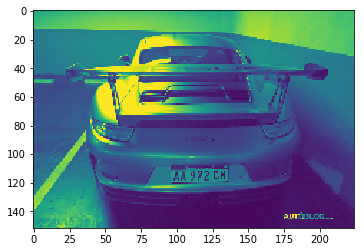

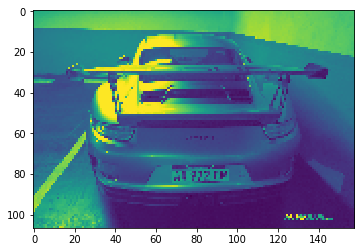

count detect: 1
show return window:  [ 544.          453.33333333] return windows box:  [ 725.33333333  816.        ]
present:  0.999554045073
letter:  AA972CW
count detect: 2
show return window:  [ 544.          464.66666667] return windows box:  [ 725.33333333  827.33333333]
present:  0.999888800504
letter:  AA972CW
count detect: 3
show return window:  [ 544.  476.] return windows box:  [ 725.33333333  838.66666667]
present:  0.998940893867
letter:  AA972CW
count detect: 4
show return window:  [ 544.          521.33333333] return windows box:  [ 725.33333333  884.        ]
present:  0.999142838428
letter:  AA972CW
count detect: 5
show return window:  [ 544.          532.66666667] return windows box:  [ 725.33333333  895.33333333]
present:  0.998152925676
letter:  AA972CW
count detect: 6
show return window:  [ 566.66666667  442.        ] return windows box:  [ 748.          804.66666667]
present:  0.991762098506
letter:  AA972CW
count detect: 7
show return window:  [ 566.66666667  453

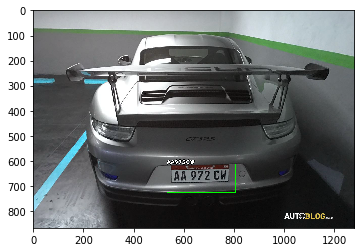

detect end 2018-10-01 09:23:30


In [30]:
detect_plate("prueba.jpg", "CPUweights_01102018.npz", "prueba.png")

detect start!  2018-10-01 09:23:30


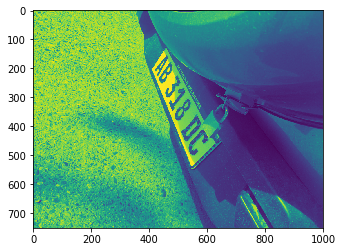

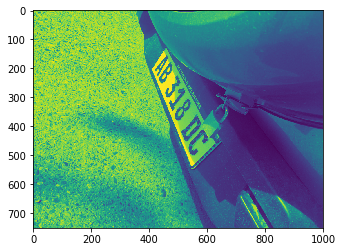

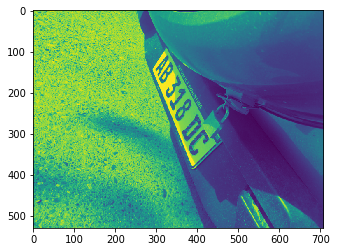

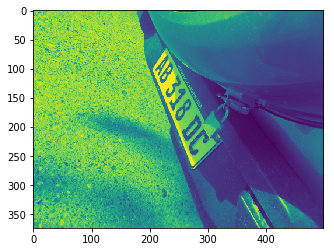

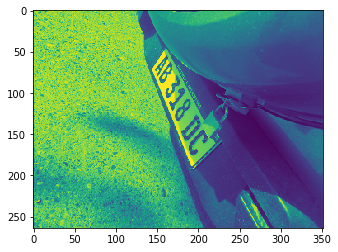

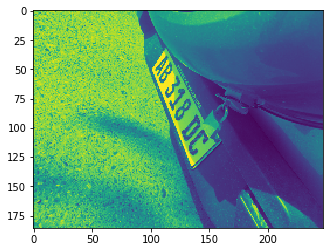

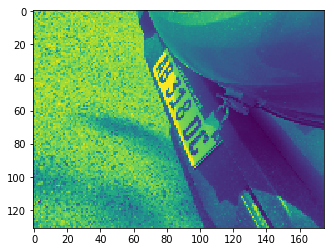

show result:


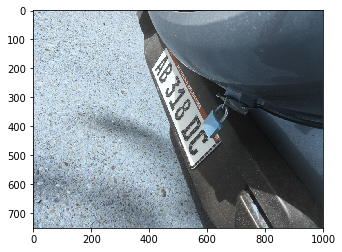

detect end 2018-10-01 09:25:37


In [31]:
detect_plate("prueba2.jpeg", "CPUweights_01102018.npz", "prueba2.png")

detect start!  2018-10-01 09:25:37


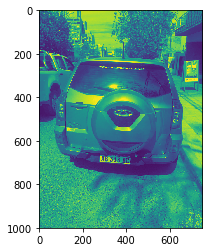

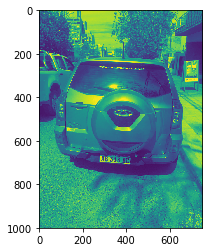

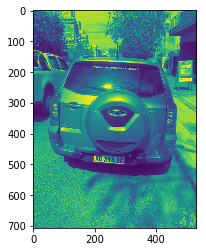

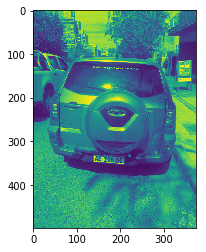

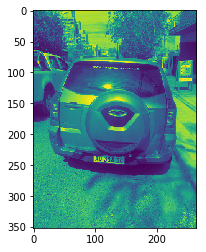

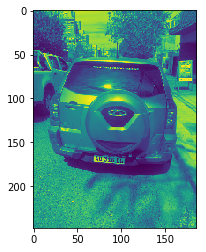

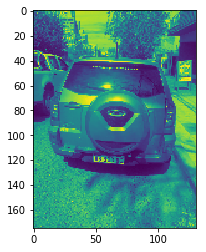

count detect: 1
show return window:  [ 622.34794908  243.281471  ] return windows box:  [ 712.87128713  424.3281471 ]
present:  0.999340829363
letter:  AB318DC
count detect: 2
show return window:  [ 622.34794908  254.59688826] return windows box:  [ 712.87128713  435.64356436]
present:  0.999977964771
letter:  AB318DC
count detect: 3
show return window:  [ 622.34794908  260.25459689] return windows box:  [ 712.87128713  441.30127298]
present:  0.99685536783
letter:  AB518DC
count detect: 4
show return window:  [ 622.34794908  265.91230552] return windows box:  [ 712.87128713  446.95898161]
present:  0.999192789503
letter:  AB328DC
count detect: 5
show return window:  [ 633.66336634  243.281471  ] return windows box:  [ 724.18670438  424.3281471 ]
present:  0.999920901042
letter:  AB118DC
count detect: 6
show return window:  [ 633.66336634  248.93917963] return windows box:  [ 724.18670438  429.98585573]
present:  0.999974465139
letter:  AB318DC
count detect: 7
show return window:  [ 63

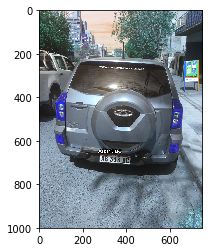

detect end 2018-10-01 09:26:35


In [32]:
detect_plate("prueba3.jpeg", "CPUweights_01102018.npz", "prueba3.png")

detect start!  2018-10-01 09:26:35


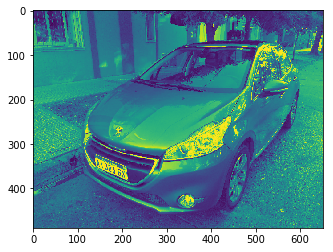

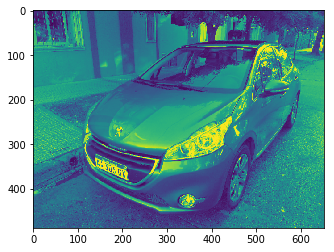

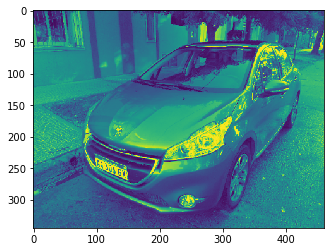

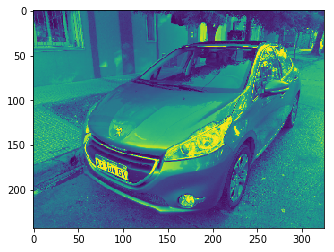

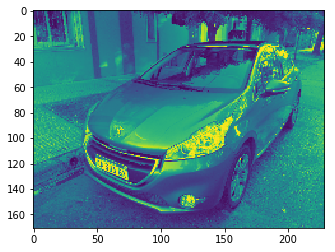

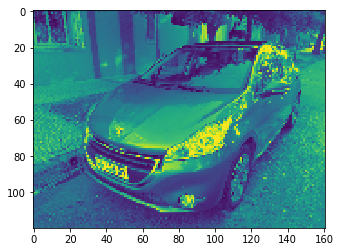

count detect: 1
show return window:  [ 328.67213115   96.19672131] return windows box:  [ 392.80327869  224.45901639]
present:  0.99283685524
letter:  SA366GX
count detect: 2
show return window:  [ 328.67213115  100.20491803] return windows box:  [ 392.80327869  228.46721311]
present:  0.991595355696
letter:  SA366GX
show result:


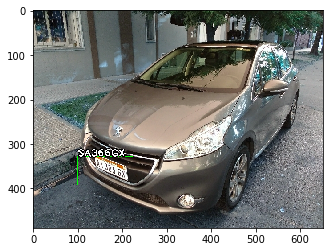

detect end 2018-10-01 09:27:00


In [33]:
detect_plate("prueba4.jpeg", "CPUweights_01102018.npz", "prueba4.png")

detect start!  2018-10-02 12:49:44


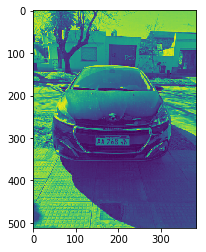

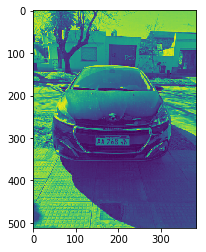

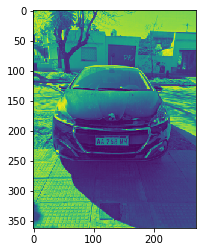

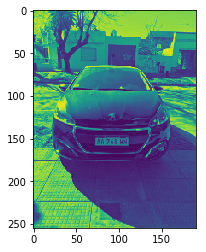

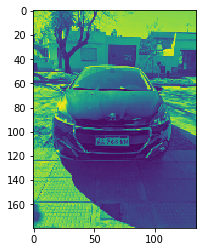

count detect: 1
show return window:  [ 280.  124.] return windows box:  [ 344.  252.]
present:  0.990951348761
letter:  AA768WN
show result:


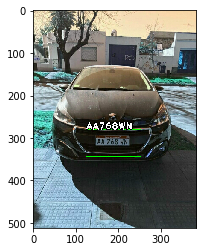

detect end 2018-10-02 12:49:56


In [36]:
detect_plate("prueba5.jpeg", "CPUweights_01102018.npz", "prueba5.png")

detect start!  2018-10-01 09:27:12


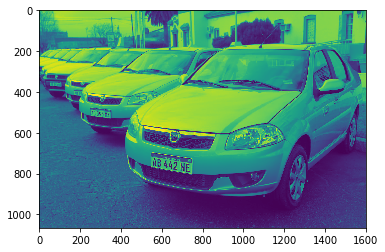

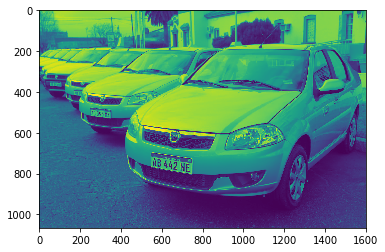

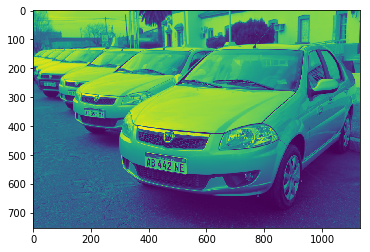

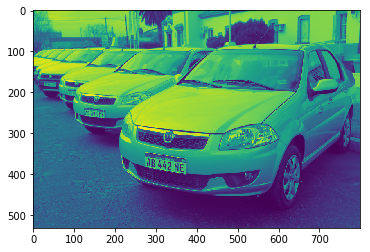

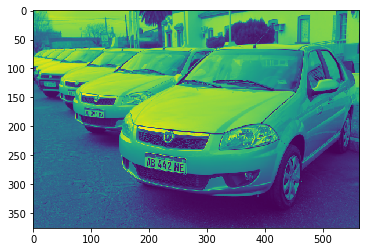

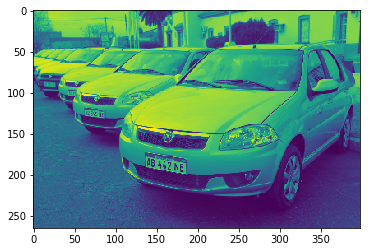

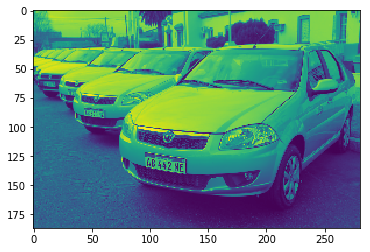

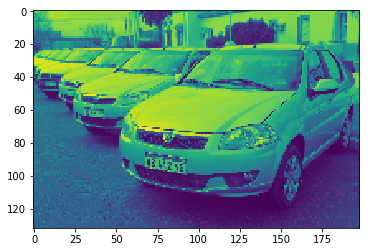

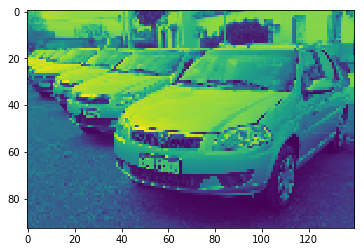

count detect: 1
show return window:  [ 472.  224.] return windows box:  [ 536.  352.]
present:  0.996311803772
letter:  AB305MT
count detect: 2
show return window:  [ 472.  228.] return windows box:  [ 536.  356.]
present:  0.999092561863
letter:  AB355MZ
count detect: 3
show return window:  [ 472.  232.] return windows box:  [ 536.  360.]
present:  0.999998036688
letter:  AB385MZ
count detect: 4
show return window:  [ 472.  236.] return windows box:  [ 536.  364.]
present:  0.999979796071
letter:  AB395MZ
count detect: 5
show return window:  [ 472.  240.] return windows box:  [ 536.  368.]
present:  0.99999193488
letter:  AB305MZ
count detect: 6
show return window:  [ 472.  244.] return windows box:  [ 536.  372.]
present:  0.999989002949
letter:  AB305MZ
count detect: 7
show return window:  [ 472.  248.] return windows box:  [ 536.  376.]
present:  0.999063353122
letter:  AB385MZ
count detect: 8
show return window:  [ 480.  224.] return windows box:  [ 544.  352.]
present:  0.9976883

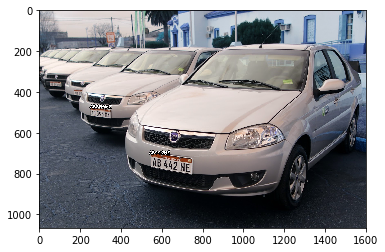

detect end 2018-10-01 09:29:40


In [35]:
detect_plate("prueba6.jpg", "CPUweights_01102018.npz", "prueba6.png")